In [1]:
import numpy as np
import matplotlib.pyplot as pyplot
from scipy.interpolate import griddata
import matplotlib.colors as colors
from functools import reduce
import time

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.model_selection import train_test_split, learning_curve, StratifiedShuffleSplit

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import DataPreprocessing

In [2]:
combs = ['1,3','1,4','2,3','2,4','1,2,3','1,2,4','2,3,4','1,3,4']

In [3]:
##Obtain & process data NPY
#me_train, mom_train_r = DataPreprocessing.npy('LO/uuxg/me_1000000.npy', 'LO/uuxg/mom_1000000.npy', ['1,3','2,3'], frac=1)
#me_test, mom_test_r = DataPreprocessing.npy('LO/uuxg/me_500000.npy', 'LO/uuxg/mom_500000.npy', ['1,3','2,3'], frac=1)

me_train, mom_train_r = DataPreprocessing.npy('LO/uuuxux/me_1000000.npy', 'LO/uuuxux/mom_1000000.npy', combs, frac=1)
me_test, mom_test_r = DataPreprocessing.npy('LO/uuuxux/me_500000.npy', 'LO/uuuxux/mom_500000.npy', combs, frac=1)


Matrix Element Prep in 1.5850 seconds
Matrix Element Prep in 0.5769 seconds


## Single Test

In [9]:
mom_train = np.array([np.ndarray.flatten(np.array(element)) for element in mom_train_r])
mom_test = np.array([np.ndarray.flatten(np.array(element)) for element in mom_test_r])

##Data transformation
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('kbins', KBinsDiscretizer(n_bins=5000)) #Checking convergence as bins.
])
 
mom_train = pipeline.fit_transform(mom_train) #Rescale on training set
mom_test = pipeline.transform(mom_test) #Rescale on test set

tic = time.perf_counter()

linreg = LinearRegression().fit(mom_train, me_train)

toc = time.perf_counter()

print(f"Ran in {toc - tic:0.4f} seconds")

Ran in 12.0357 seconds


In [10]:
tic = time.perf_counter()

me_predict_lin = linreg.predict(mom_test)

toc = time.perf_counter()

np.save('LO/uuuxux/pred_kbins.npy', me_predict_lin)
print(f"Ran in {toc - tic:0.4f} seconds")

Ran in 0.0498 seconds


In [11]:
lin_mse = mean_squared_error(me_test, me_predict_lin) 
print('RMSE Test: {}'.format(np.sqrt(lin_mse)))

lin_mse = mean_squared_error(me_train, linreg.predict(mom_train))
print('RMSE Train: {}'.format(np.sqrt(lin_mse)))

lin_perc = 100*np.mean(np.divide(np.abs(me_test - me_predict_lin), me_test))
print('Percentage Error: {}'.format(lin_perc))

RMSE Test: 1.6552626932721157e+31
RMSE Train: 1.5246144714812387e+31
Percentage Error: 678.7279268958463


In [7]:
print(me_predict_lin[:5])
print(me_test[:5])
print(np.divide(np.abs(me_test - me_predict_lin), me_test))

[24855.8111631  74003.57887303 37458.43422551 49955.41926214
 47470.35463948]
[24854.26712587 74003.41493626 37459.82819949 49951.45712264
 47474.96128204]
[6.21236272e-05 2.21525944e-06 3.72125032e-05 ... 1.85523156e-04
 5.16645775e-05 3.84110370e-05]


Plotting Learning Curve

In [7]:
##Plotting a Learning Curve
split = StratifiedShuffleSplit() #Collects data evenly about mean to put into validation sets
train = split.split(mom_train, pd.cut(me_train, bins = 200)) #But are we testing on something we've trained..?

train_sizes, train_scores, test_scores = learning_curve(
        linreg, mom_train, me_train, scoring='neg_mean_squared_error',
        cv=5, shuffle=True, train_sizes=np.linspace(0.1, 1, 6), 
        n_jobs=1, verbose=1)

[learning_curve] Training set sizes: [ 800 2240 3679 5120 6560 8000]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.5s finished


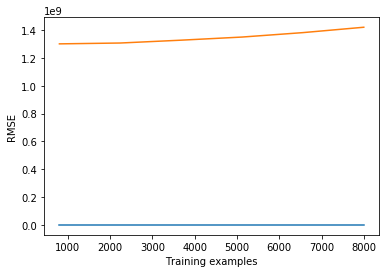

In [8]:
pyplot.figure()

train_scores_mean = np.sqrt(-np.mean(train_scores, axis=1))
test_scores_mean = np.sqrt(-np.mean(test_scores, axis=1))

pyplot.plot(train_sizes, train_scores_mean)
pyplot.plot(train_sizes, test_scores_mean)

pyplot.xlabel("Training examples")
pyplot.ylabel("RMSE")
pyplot.savefig('LearningCurveKBins')

Error Distribution 3-jets

In [7]:
#s12, s13, s23 = DataPreprocessing.mandel_creation(['3,4','3,5','4,5'], mom_test)
s12, s13, s23 = DataPreprocessing.mandel_creation(['1,2','1,3','2,3'], mom_test_r)
S = s12 + s13 + s23

In [8]:
x1 = np.divide(s12, 1000000)
x2 = np.divide(s13, 1000000)
x3 = np.divide(s23, 1000000)

x2i = np.linspace(0, 1, 500) #x1 coordinates
x3i = np.linspace(0, 1, 500) #x2 coordinates
X2i, X3i = np.meshgrid(x2i, x3i) #2d regularly spaced grid of coordinates.

In [9]:
#Value at grid coordinate is mapped to the nearest actual datapoint.
grid = griddata((x2, x3), 100*np.divide(np.abs(me_test - me_predict_lin), me_test), (X2i, X3i), method='linear')
#grid = griddata((x2, x3), me_test, (X2i, X3i), method='linear')

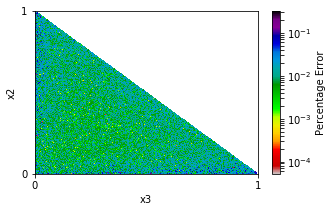

In [10]:
fig, ax = pyplot.subplots(figsize=(5, 3))
im = ax.pcolor(grid, cmap = 'nipy_spectral_r', norm = colors.LogNorm()) #color map of coord grid
cbar = ax.figure.colorbar(im)
cbar.set_label('Percentage Error')

ax.set_xticks([0, 500])
ax.set_xticklabels([0, 1])
ax.set_yticks([0, 500])
ax.set_yticklabels([0, 1])


ax.set_ylabel('x2')
ax.set_xlabel('x3')
pyplot.savefig('errordalitz_kbins_3jetLO')

## Plot accuracy vs number of bins

In [30]:
def changeBins(n_bins, input_train, input_test, output_train, output_test):
    input_train = np.array([np.ndarray.flatten(np.array(element)) for element in input_train])
    input_test = np.array([np.ndarray.flatten(np.array(element)) for element in input_test])

    ##Data transformation
    pipeline = Pipeline([
        ('scaler', StandardScaler()), #Rescale Data.
        ('kbins', KBinsDiscretizer(n_bins=n_bins)) #Checking convergence as bins.
    ])

    temp_train = pipeline.fit_transform(input_train) #Rescale on training set
    temp_test = pipeline.transform(input_test) #Rescale on test set
    
    linreg = LinearRegression().fit(temp_train, output_train)

    me_predict = linreg.predict(temp_test) #Prediction on test set
    lin_mse = mean_squared_error(output_test, me_predict) 
    
    #print(np.divide(np.abs(output_test - me_predict), output_test))
    lin_perc = 100*np.mean(np.divide(np.abs(output_test - me_predict), output_test))
    
    return lin_perc

In [18]:
##Obtain & process data
me_train, mom_train_r = DataPreprocessing.npy('LO/MG_uuuxux/me_4jet_1000000', 'LO/MG_uuuxux/mom_4jet_1000000', 
                                            ['1,3','1,4','2,3','2,4'], 10000, frac=1)
me_test, mom_test_r = DataPreprocessing.npy('LO/MG_uuuxux/me_4jet_100000', 'LO/MG_uuuxux/mom_4jet_100000', 
                                          ['1,3','1,4','2,3','2,4'], 10000, frac=1)

train = reduce(np.multiply, DataPreprocessing.mandel_creation(['1,3,4',',2,3,4','1,2,3','1,2,4'], mom_train_r))**0.5
test = reduce(np.multiply, DataPreprocessing.mandel_creation(['1,3,4',',2,3,4','1,2,3','1,2,4'], mom_test_r))**0.5
mom_train = np.multiply(mom_train, train)
mom_test = np.multiply(mom_test, test)

mom_train = np.append(mom_train, DataPreprocessing.mandel_creation(combs, mom_train_r).T, axis=1)
mom_test = np.append(mom_test, DataPreprocessing.mandel_creation(combs, mom_test_r).T, axis=1)

n_bins_arr = range(100, 10000, 1000)
result = []
for n_bins in n_bins_arr:
    temp = changeBins(n_bins, mom_train, mom_test, me_train, me_test)
    print(temp)
    result.append(temp)

TypeError: npy() got multiple values for argument 'frac'

In [39]:
##Obtain & process data NPY
me_train, mom_train_r = DataPreprocessing.npy('LO/MG_uuxg_2/me_1000000.npy', 'LO/MG_uuxg_2/mom_1000000.npy', ['1,3','2,3'], frac=1)
me_test, mom_test_r = DataPreprocessing.npy('LO/MG_uuxg_2/me_100000.npy', 'LO/MG_uuxg_2/mom_100000.npy', ['1,3','2,3'], frac=1)

n_bins_arr = range(100, 40000, 2000)
result = []
for n_bins in n_bins_arr:
    temp = changeBins(n_bins, mom_train_r, mom_test_r, me_train, me_test)
    print(temp)
    result.append(temp)

0.6517975281205803
0.034609508228348844
0.018639755985720034
0.013107974813697881
0.010327075990377422
0.008586756503293129
0.00752111688656486
0.006661267489600375
0.0061180180881149696
0.005650942353333651
0.005259559702533493
0.004982432234513525
0.004753333694589214
0.004554394810304656
0.004355643506653321
0.004236753669571044
0.004152420915535677
0.004062588831362679
0.0039990266045571475
0.003948834293025016


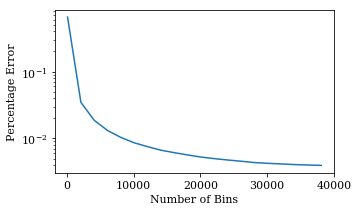

In [40]:
from matplotlib import rcParams

rcParams['font.family'] = 'Serif'
rcParams['font.size'] = 11

fig = pyplot.figure(figsize=(5, 3))

pyplot.xlabel('Number of Bins')
pyplot.ylabel('Percentage Error')
pyplot.plot(n_bins_arr, result)

pyplot.yscale('log')
pyplot.savefig('KBINS_NBins.png')

In [38]:
print(np.mean(me_test))

27820.578600538574


In [39]:
print(np.std(me_test))

41758.90805249425
